In [1]:
from PIL import Image
import numpy as np
import random
import time
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
import os
import glob

## 1 Generate a Test Map

draw a simplified pixel map on https://www.pixilart.com/draw?ref=home-page#

In [2]:
# read a pixel map with marked intersection
mapname = 'test/default_map_0.png'
image = Image.open(mapname)

In [3]:
intersectionMap = np.asarray(image).T[0].T
laneMap = np.asarray(image).T[-1].T
map = np.where(intersectionMap==0, intersectionMap, 1) + np.where(laneMap==0, intersectionMap, 1)

In [4]:
# img = Image.fromarray(map*127,"L")

## Animation Helper
not important

In [24]:
class Animator():
    """初始化横轴,x/ylabel,"""
    def __init__(self, xlim, xlabel=None, ylabel=None, legend=None,ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'),figsize=(3.5, 2.5),dirname=None) -> None:
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xscale = xscale
        self.yscale = yscale
        self.xlim = xlim
        self.ylim = ylim
        self.legend = legend
        # 图例显示
        if legend is None:
            legend = []
        # 使用svg图像显示
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(figsize=figsize)
        self.x = None
        self.y = None
        self.fmts = fmts
        self.dirname = dirname

    def set_axes(self):
        # 设置轴上的属性
        self.axes.set_xlabel(self.xlabel)
        self.axes.set_ylabel(self.ylabel)
        self.axes.set_xscale(self.xscale)
        self.axes.set_yscale(self.yscale)
        self.axes.set_xlim(self.xlim)
        self.axes.set_ylim(self.ylim)
        if self.legend:
            self.axes.legend(self.legend)
        self.axes.grid()


    def show(self,x,y):
        self.axes.cla()
        self.axes.plot(x[0],y[0], self.fmts[0], linewidth=2.5)
        self.axes.scatter(x[1],y[1], linewidth=2.5)
        self.set_axes()
        if self.dirname:
            plt.savefig('%s/%s_%s.png'%(self.dirname,mapname,time.time()))
        display.display(self.fig)
        display.clear_output(wait=True)

In [28]:
def draw(fig, point,x,y):
    print(point)
    x[0].append(point[0])
    y[0].append(point[1])

    x[1]=[point[0]]
    y[1]=[point[1]]

    fig.show(y,x)
    time.sleep(0.25)

## 2 Pseudo

In [25]:
def isLane(point):
    x,y = point
    if 0 <= x <= map.shape[0]-1 and 0 <= y <= map.shape[1]-1 :
        if map[x][y] == 1:
            return True
    return False

def isIntersection(point):
    x,y = point
    if 0 <= x <= map.shape[0]-1 and 0 <= y <= map.shape[1]-1 :
        if map[x][y] == 2:
            return True
    return False


def initialStartpoint():
    while True:
        x = random.randint(0,map.shape[0]-1)
        y = random.randint(0,map.shape[1]-1)
        if isLane((x,y)):
            break
    return (x,y)

def initialStartdirection(startPoint):
    directions =  [(0,-1),(0,1),(-1,0),(1,0)]
    while True:
        i = random.randint(0,3)
        x = startPoint[0]+directions[i][0]
        y = startPoint[1]+directions[i][1]
        # if out of range, change to the next direction
        if isLane((x,y)) or isIntersection((x,y)):
            break
    return (x,y)


In [26]:
def driveOneStepForward(currentPoint, nextPoint):
    # stop by intersection
    if isIntersection(nextPoint):
        return (currentPoint, nextPoint, True)
    else:
        # find the next direction
        directions =  [(0,-1),(0,1),(-1,0),(1,0)]
        lastpoint = currentPoint
        currentPoint = nextPoint
        for (x,y) in directions:
            nextPoint = (currentPoint[0]+x,currentPoint[1]+y)
            if nextPoint != lastpoint:
                if isLane(nextPoint) or isIntersection(nextPoint):
                    return (currentPoint, nextPoint, False)
        # if dead end, go back
        return (currentPoint, lastpoint, isIntersection(lastpoint))

def driveForward(currentPoint, nextPoint):
    isIntersection = False
    while not isIntersection:
        (currentPoint, nextPoint, isIntersection) = driveOneStepForward(currentPoint, nextPoint)
    return (currentPoint, nextPoint, True)
                
def driveTurnLeft(currentPoint, nextPoint):
    # if not intersection cannot turn left
    if not isIntersection(nextPoint):
        return (currentPoint, nextPoint, False)
    else:
        lastpoint = currentPoint
        currentPoint = nextPoint # go into the intersection
        while True:
            originalDirection = np.matrix([currentPoint[0]-lastpoint[0],currentPoint[1]-lastpoint[1]])
            turnLeftMat = np.matrix([[0,1],[-1,0]])
            newDirection = originalDirection*turnLeftMat
            x = np.asarray(newDirection)[0][0]
            y = np.asarray(newDirection)[0][1]
            nextPoint = (currentPoint[0]+x,currentPoint[1]+y)
            if isLane(nextPoint):
                return (currentPoint, nextPoint, False)
            else:
                lastpoint = nextPoint

In [27]:
def getIntersectionExits(intersection):
    exits = []
    for (x,y) in [(0,-1),(0,1),(-1,0),(1,0)]:
        nextPoint = (intersection[0]+x,intersection[1]+y)
        if isLane(nextPoint) or isIntersection(nextPoint):
            exits.append(nextPoint)
    return exits

In [29]:
def initialMap(currentPosition, nextPosition, fig):
    # for draw
    x = [[],[]]
    y = [[],[]]

    # draw start step
    draw(fig, currentPosition,x,y)
    
    intersectionSet = {}
    unfinishedIntersection = []

    lastIntersection = None
    isIntersection_ = False
    
    # drive forward until reach a intersection
    while not isIntersection_:

        # (currentPosition, currentIntersection, isIntersection_) = driveForward(startPoint, startDirection)
        (currentPosition, nextPosition, isIntersection_) = driveOneStepForward(currentPosition, nextPosition)

        draw(fig, currentPosition, x, y)

        if isIntersection_:
            currentIntersection = nextPosition
            exits = getIntersectionExits(currentIntersection)

            # get an exit from the intersection
            # if the intersection is new
            if currentIntersection not in intersectionSet:
                # intersection structure
                intersectionSet[currentIntersection] = {"exits":{},"neighbors":[], "connections":{} } 

                # mark the unvisited exits
                for e in exits:
                    intersectionSet[currentIntersection]["exits"][e]=False
                    # mark the current exit(entrance) as visited
                    if currentPosition in exits:
                        intersectionSet[currentIntersection]["exits"][currentPosition]=True
                    else:
                        #error
                        print("coordinate error. at: %s, list:%s"%(currentPosition,exits))
                        exit()
                
                # mark connection
                if lastIntersection != None:
                    intersectionSet[currentIntersection]["connections"][currentPosition] = lastIntersection
                lastIntersection = currentIntersection
                unfinishedIntersection.append(currentIntersection)

                # turn left
                (currentPosition, nextPosition, isIntersection_) = driveTurnLeft(currentPosition, currentIntersection)
                intersectionSet[currentIntersection]["exits"][nextPosition]=True
            
            # got here once before
            else:
                intersectionSet[currentIntersection]["exits"][currentPosition]=True
                intersectionSet[currentIntersection]["connections"][currentPosition] = lastIntersection
                originalEntrance = currentPosition
                while True:
                    # turn left
                    # intersection,out = in,intersection
                    (currentIntersection, currentPosition, isIntersection_) = driveTurnLeft(currentPosition, currentIntersection)
                    # if out is not visited
                    if not intersectionSet[currentIntersection]["exits"][currentPosition]:
                        nextPosition = currentPosition
                        currentPosition = currentIntersection
                        intersectionSet[currentIntersection]["exits"][nextPosition]=True
                        break
                    else:
                        exits.remove(currentPosition)
                    if exits == []:
                        if currentIntersection in unfinishedIntersection:
                            unfinishedIntersection.remove(currentIntersection)
                        # TODO: choose an exit which has connection to a unfinished Intersection
                        # current: choose the left exit
                        (currentPosition, nextPosition, isIntersection_) = driveTurnLeft(originalEntrance, currentIntersection)
                        break
        
        
            draw(fig, currentPosition, x, y)
        
        # if unfinishedIntersection == []:
        #     break

## Run for an example

In [57]:
startPoint = initialStartpoint()
startDirection = initialStartdirection(startPoint)
print("current position:\t%s\nnext position:\t\t%s"%(startPoint, startDirection))

current position:	(1, 9)
next position:		(0, 9)


(7, 12)


KeyboardInterrupt: 

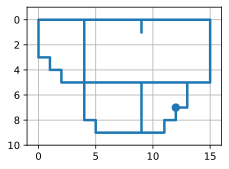

In [59]:
dirname = time.time()
os.makedirs("img/%s"%dirname)

fig = Animator(xlim=(-1,map.shape[1]),ylim=(map.shape[0],-1),dirname="img/%s"%dirname)
initialMap(startPoint, startDirection, fig)

In [61]:
search_dir = "img/%s/"%dirname
# remove anything from the list that is not a file (directories, symlinks)
# thanks to J.F. Sebastion for pointing out that the requirement was a list 
# of files (presumably not including directories)  
files = list(filter(os.path.isfile, glob.glob(search_dir + "*")))
files.sort(key=lambda x: os.path.getmtime(x))

frames = [Image.open(image) for image in files]
frame_one = frames[0]
frame_one.save("%s.gif"%search_dir, format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)